# Hand Written Digit Recognition using Neural Networks

This notebook is created in attemp to participate in a coursera challenge. The data is availble on kaggle.


As usual, import all neccasary stuff into the notebook.

In [1]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First, I will start by loading the data in panda dataframe and do some EDA.

In [16]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
print(train.shape,test.shape)

((42000, 785), (28000, 784))


It appears that the test data has no label and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only.
Next, split the train,test dataframe into X and Y dataframe where X store the data while Y store the label.

In [17]:
X = train.copy()
X = X.drop('label',axis=1)
Y = pd.DataFrame(train['label'])

In [18]:
print(X.shape,Y.shape)

((42000, 784), (42000, 1))


Lets take a look at class distribution, the distribution is quite uniform so the problem may not need to be treated as imbalance dataset.

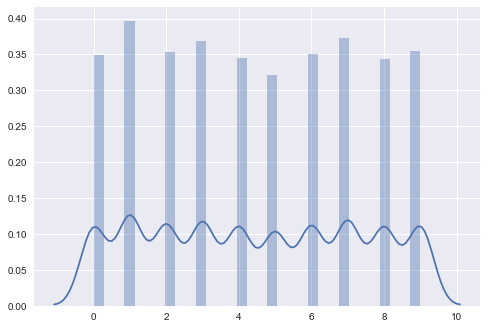

In [19]:
#Y_dist=pd.DataFrame(Y.label.value_counts())
#Y_dist = Y_dist.reset_index()
#Y_dist.columns = ['label','count']
#Y_dist = Y_dist.set_index('label').sort_index().reset_index()
sns.distplot(Y);

Import and play around with basic neural network using neupy library. Starting with only one layer first.

Change the format of the data to be compatible with neupy library

In [22]:
from sklearn.preprocessing import OneHotEncoder
X = X/255.
X = X - X.mean(axis=0)
target_scaler = OneHotEncoder()
Y = target_scaler.fit_transform(Y.values.reshape((-1, 1)))
Y = Y.todense()

Check the format

In [24]:
print(X.shape,Y.shape)

((42000, 784), (42000, 10))


In [25]:
import theano
theano.config.floatX = 'float32'

Start one layer neural network training, using adam as back propogation technique.

Adamax back propogation seems to do good job training with 100 epoch. This will be basic information that I will use later.

Use all available data in X and Y array to train with CV.

In [63]:
import shelve
s = shelve.open('Neural_1layer_CV.db', writeback=True)
from sklearn.model_selection import KFold
kf = KFold(5)
kf.get_n_splits(X)
kcount =0
for train_index, test_index in kf.split(X):
    kcount = kcount+1
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_T = X.loc[train_index]
    X_CV = X.loc[test_index]
    Y_train_T = Y[train_index]
    Y_CV = Y[test_index]
    from neupy import algorithms, layers
    network = algorithms.Adamax([layers.Input(784),layers.Relu(500),layers.Softmax(10)],\
                          error='categorical_crossentropy',step = 0.001,verbose=False,\
                          shuffle_data=True)
    network.architecture()
    network.train(X_train_T,Y_train_T,X_CV,Y_CV,epochs=50)
    s['Network'+str(kcount)]=network
s.close()

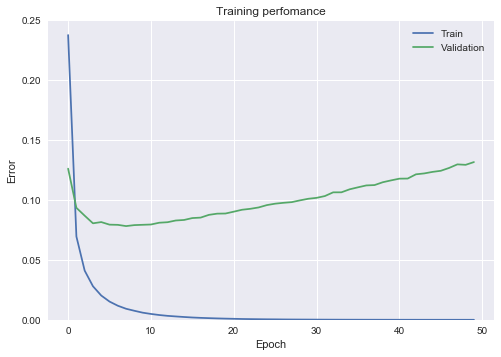

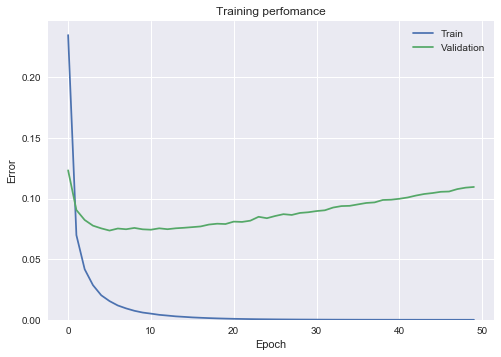

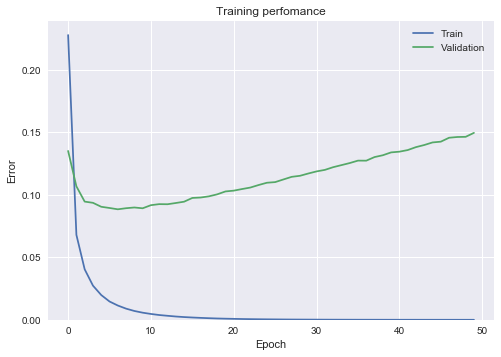

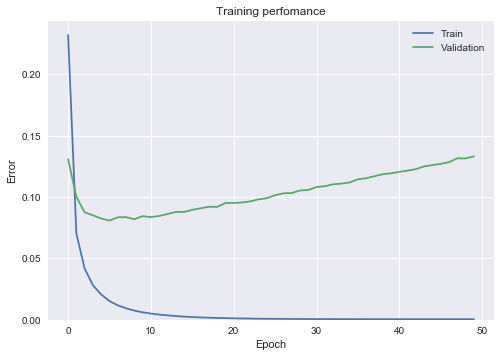

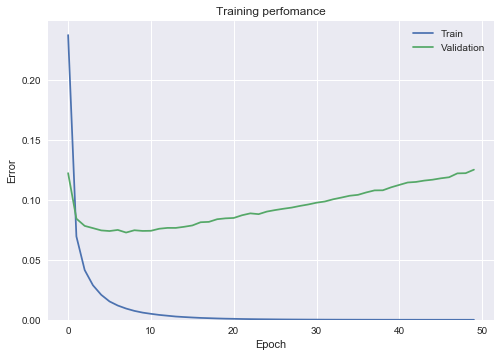

In [72]:
from neupy import plots
for k in range(len(kf.get_n_splits(X)):
    plots.error_plot(s['Network'+str(k)])

The code for simple 5-fold cross-validation works for simple one layer of neural network setting. Next I try hyperparameter optimization on one hidden layer first with the use of PZE. Using accuracy as evaluation metric.
Using dropout as a mean to regularized the neural network model.
- Hidden Layer size (50,500)
- Dropupt Layer (0,0.5)
- Activation Function
    - Relu
    - PRelu
    - Tanh
    - Sigmoid
    - Elu

In [ ]:
%%bash
git add Handwritten_Neural.ipynb
git commit -m 'Add code that should run hyper search for one layer'
git push

In [ ]:
from pprint import pprint
from functools import partial

import theano
import numpy as np
from sklearn import model_selection, datasets, preprocessing, metrics
import hyperopt
from hyperopt import hp
from neupy import algorithms, layers, environment
from neupy.exceptions import StopTraining

theano.config.floatX = 'float32'

def on_epoch_end(network):
    if network.errors.last() > 10:
        raise StopTraining("Training was interrupted. Error is to high.")

def train_network(parameters):
    print("Parameters:")
    pprint(parameters)
    print()

    step = parameters['step']
    batch_size = int(parameters['batch_size'])
    proba = parameters['dropout']
    activation_layer = parameters['act_func_type']
    layer_sizes = [int(n) for n in parameters['layers']['n_units_layer']]
    
    network = layers.Input(784)

    for layer_size in layer_sizes:
        network = network > activation_layer(layer_size)

    network = network > layers.Dropout(proba) > layers.Softmax(10)
    
    mnet = algorithms.Adamax(
        network,

        batch_size=batch_size,
        step=step,
        
        error='categorical_crossentropy',
        shuffle_data=True,
        
        epoch_end_signal=on_epoch_end,
    )
    
    from sklearn.model_selection import KFold
    kf = KFold(5)
    score_temp = []
    acc_temp =[]
    kcount =0
    for train_index, test_index in kf.split(X):
        kcount = kcount+1
        X_CV = X.loc[test_index]
        Y_CV = Y[test_index]
        mnet.train(X.loc[train_index], Y[train_index], epochs=50)
        score_temp.append(mnet.prediction_error(X.loc[test_index], Y[test_index]))
        y_predicted = mnet.predict(X.loc[test_index]).argmax(axis=1)
        acc_temp.append(metrics.accuracy_score(y_test.argmax(axis=1), y_predicted))
    
    #score = mnet.prediction_error(x_test, y_test)
    score = np.mean(score_temp)
    #y_predicted = mnet.predict(x_test).argmax(axis=1)
    accuracy = np.mean(acc_temp)
    
    print("Final score: {}".format(score))
    print("Accuracy: {:.2%}".format(accuracy))

    return score

In [ ]:
def uniform_int(name, lower, upper):
    # `quniform` returns:
    # round(uniform(low, high) / q) * q
    return hp.quniform(name, lower, upper, q=1)

def loguniform_int(name, lower, upper):
    # Do not forget to make a logarithm for the
    # lower and upper bounds.
    return hp.qloguniform(name, np.log(lower), np.log(upper), q=1)

In [ ]:
environment.reproducible()
# Object stores all information about each trial.
# Also, it stores information about the best trial.
trials = hyperopt.Trials()

parameter_space = {
    'step': hp.uniform('step', 0.01, 0.5),
    'layers': hp.choice('layers', [{
        'n_layers': 1,
        'n_units_layer': [
            uniform_int('n_units_layer_11', 50, 500),
        ],
    }]),
    'act_func_type': hp.choice('act_func_type', [
        layers.Relu,
        layers.PRelu,
        layers.Elu,
        layers.Tanh,
        layers.Sigmoid
    ]),
    
    'dropout': hp.uniform('dropout', 0, 0.5),
    'batch_size': loguniform_int('batch_size', 128, 128),
}

In [ ]:
tpe = partial(
    hyperopt.tpe.suggest,

    # Sample 1000 candidate and select candidate that
    # has highest Expected Improvement (EI)
    n_EI_candidates=1000,
    
    # Use 20% of best observations to estimate next
    # set of parameters
    gamma=0.2,
    
    # First 20 trials are going to be random
    n_startup_jobs=20,
)

hyperopt.fmin(
    train_network,
    trials=trials,
    space=parameter_space,

    # Set up TPE for hyperparameter optimization
    algo=tpe,

    # Maximum number of iterations. Basically it trains at
    # most 200 networks before choose the best one.
    max_evals=200,
)